<a href="https://colab.research.google.com/github/nparslow/disfluency_gen/blob/develop/docs/tutorials/nmt_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# refactored from:
#https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb

import os
import sys
repoRoot = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(repoRoot, "src", "disfluency_generator"))

import tensorflow as tf
from machine_translator import load_data, create_dataset, print_examples, tf_lower_and_split_punct,\
    create_text_processor
from encoder import Encoder
from decoder import Decoder
from trainTranslator import TrainTranslator, BatchLogs
from maskedLoss import MaskedLoss

from translator import Translator
from trainTranslator import TrainTranslator

import pathlib

from letsread_prepare_translations import LetsReadDataPrep
from portuguese_phoneme_to_grapheme import PhonemeToGrapheme


In [2]:
# load data
data_path = pathlib.Path(repoRoot, "data")
verbose = 1
#------------------
letsread_corpus_path = os.path.join(data_path, "LetsReadDB")

p2g = PhonemeToGrapheme(os.path.join(repoRoot, "resources", "sampa.tsv"))
inputs, targets = LetsReadDataPrep(letsread_corpus_path, p2g).prep_letsread()

if verbose > 0:
    print(f"Last example of data:\n{inputs[-1]}\n{targets[-1]}")

# we'll leave off the first 20 as a test set (todo improve)
dataset = create_dataset(inputs[20:], targets[20:], BATCH_SIZE=64)

if verbose > 0:
    print("Printing Examples (before normalisation):")
    print_examples(dataset)

# todo - check with corpus:
max_vocab_size = 5000

input_text_processor = create_text_processor(inputs, max_vocab_size)

if verbose > 0:
    # todo better checking:
    print("First 10 words of input vocab:")
    print(input_text_processor.get_vocabulary()[:10])

# note - we don't have to have the same output vocab size:
output_text_processor = create_text_processor(targets, max_vocab_size)

if verbose > 0:
    print("First 10 words of target vocab:")
    print(output_text_processor.get_vocabulary()[:10])

if verbose > 0:
    for example_input_batch, example_target_batch in dataset.take(1):
        print("Example input token sequences (indices):")
        example_tokens = input_text_processor(example_input_batch)
        print(example_tokens[:3, :10])


Cannot parse t6j~ at ~
Cannot parse lun6w at w
Cannot parse fi...ka...@ju at ju
Cannot parse kumunica at ca
Cannot parse gOc6~w~ at c6~w~
Cannot parse tevulz6w~ at w~
Cannot parse sÂj~ at Âj~
Cannot parse k6ir6w~ at w~
Cannot parse mej at j
Last example of data:
flole mocla ambife dantrar mever
flole mocla ambife dantrar e mever
tf.Tensor(
[b'Os seus ombros estavam cobertos por um manto verde e o seu vestido era da cor da chama viva.'
 b'O Sol \xc3\xa9 uma enorme bola de g\xc3\xa1s quente, que se formou a partir de uma nuvem de g\xc3\xa1s e de p\xc3\xb3 que flutuava no espa\xc3\xa7o.'
 b'Quando eu era nova tinha namorados que me diziam que eu era linda e me atiravam cravos quando eu passava.'
 b'Falaram de vento, chuva, frio, enfim, s\xc3\xb3 de coisas desagrad\xc3\xa1veis.'
 b'A Ester apaga as sete velas.'], shape=(5,), dtype=string)

tf.Tensor(
[b'os seus ombros estavam cobertos por um manto verde e o seu vestido era de core da chama viva'
 b'o sol \xc3\xa9 uma enorme bola de g\xc3\x

Before getting into it define a few constants for the model:

In [3]:
embedding_dim = 256
units = 1024

Now that you're confident that the training step is working, build a fresh copy of the model to train from scratch:

### Train the model

While there's nothing wrong with writing your own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code. 

This tutorial only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [4]:

batch_loss = BatchLogs('batch_loss')

In [5]:

train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)


In [7]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
36/36 [==============================] - 92s 3s/step - batch_loss: 6.5415
Epoch 2/3
36/36 [==============================] - 96s 3s/step - batch_loss: 5.7733
Epoch 3/3
36/36 [==============================] - 103s 3s/step - batch_loss: 5.2683


Text(0, 0.5, 'CE/token')

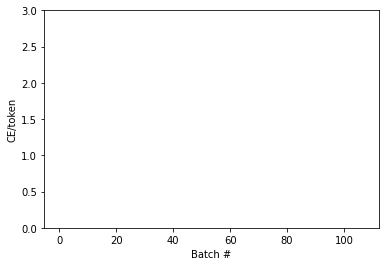

In [8]:
import matplotlib.pyplot as plt
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [9]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [12]:
model_name = 'portugues_trial_1'
tf.saved_model.save(translator, model_name,
                    signatures={'serving_default': translator.tf_translate})


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: portugues_trial_1/assets


INFO:tensorflow:Assets written to: portugues_trial_1/assets


In [13]:
#model_name = 
reloaded = tf.saved_model.load(model_name)


In [19]:
# testing
#three_input_text = tf.constant([
#    # This is my life.
#    'Esta es mi vida.',
#    # Are they still home?
#    '¿Todavía están en casa?',
#    # Try to find out.'
#    'Tratar de descubrir.',
#])
test_sentences = tf.constant(inputs[:20])  #targets[20:]

result = reloaded.tf_translate(test_sentences)

for orig, tr in zip(test_sentences, result['text']):
    print(orig.numpy().decode())
    print(tr.numpy().decode())
    print("------------")

print()

O carro do meu tio é azul.
ela para o mustra o branco havia
------------
Era uma vez um elefante muito pequenino e muito enfezado.
os burro uma fila caim todo uma encostada apareceu o teve ja palacio que o ce mas uma cravalos saboroso
------------
Desta vez contou com uma voz mais alegre e um aperto no coração.
um fiz e de seguinte que primeira culera
------------
Ontem a Joaninha fez um lindo desenho.
quero parece ana gostava poeirinha
------------
O vento amainou.
o belo gelo cimco ausencia
------------
Era uma bela casa.
uma esperteza ja e o cedo que os padrinhos as vezinho e os osso
------------
Parecia que toda a sabedoria da terra estava reunida naquela sala.
a mara essa falanos
------------
Os Maias vieram habitar uma casa em Lisboa no Outono de mil oitocentos e setenta e cinco.
jame peiza a caule havia de tecnologia
------------
Quem quer casar com a Carochinha, que é formosa e bonitinha?
que aquela degelo aprezemtoce reservara
------------
Parecia que as ondas iam cercar a cas